In [2]:
from paths import paths
import torch
import os
import pickle
import matplotlib.pyplot as plt
from tokenizers import Tokenizer
import sys
from transformer_components import (
    TransformerEncoderDecoder,
    get_causal_mask,
)
from image_captioner import ImageEncoder, CaptionDecoder
import yaml
from coco_loader import get_coco_loader, ImgFirstDataset, decode_predictions
from image_transforms import encoder_image_transform_index
from PIL import Image
import matplotlib.pyplot as plt
import evaluate
from tqdm import tqdm
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR, LinearLR, SequentialLR

/Users/michaelkosmider/miniconda3/envs/cap_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
checkpoint_path = os.path.join(paths["encoder_checkpoint"], "checkpoint9.pt")

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, pickle_module=pickle)
else:
    print(f"The path {checkpoint_path} does not exist!")
    sys.exit(1)

In [4]:
checkpoint["history"]["train_losses"]

[1.0062500326815298,
 0.7007561466988113,
 0.6291822006184039,
 0.58642480746543,
 0.5372032683374266,
 0.4941510334689865,
 0.46275282960574504,
 0.4384837881109472,
 0.42344415522480416]

/var/folders/fh/1y5zmgwd69b0g1w1mbx7cng00000gn/T/ipykernel_96731/1027359375.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


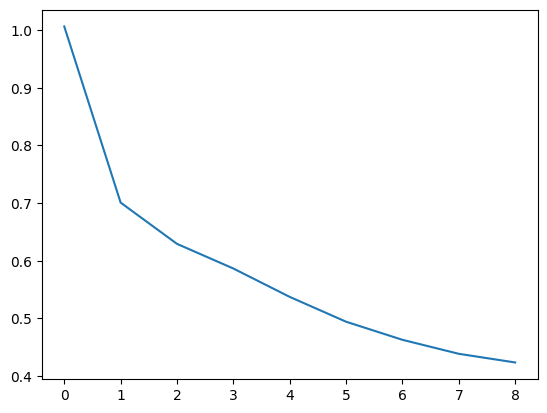

In [ ]:
fig, ax = plt.subplots()
ax.plot(checkpoint["history"]["train_losses"])

In [4]:
checkpoint["history"]["val_losses"]

[3.7227544740124054,
 2.8737551634618175,
 2.646490131846526,
 2.5213069542209086,
 2.4634686428933996,
 2.424897178361046,
 2.3987494962122535,
 2.3912988885576345,
 2.38859367442256]

In [5]:
tokenizer = Tokenizer.from_file(paths["tokenizer"])
with open(paths["config"], "r") as f:
    config = yaml.safe_load(f)
# Set device.
if "device" in config:
    device = config["device"]
else:
    device = (
        "cuda"
        if torch.cuda.is_available()
        else "mps" if torch.backends.mps.is_available() else "cpu"
    )
print(f"You are using {device}.")

You are using cuda.


In [6]:
SOS_IDX = tokenizer.token_to_id("<SOS>")
EOS_IDX = tokenizer.token_to_id("<EOS>")
PAD_IDX = tokenizer.token_to_id("<PAD>")

BATCH_SIZE = config["batch_size"]
NUM_WORKERS = config["num_workers"]

VOCAB_SIZE = config["vocab_size"]
CONTEXT_SIZE = config["context_size"]
PATCH_SIZE = config["patch_size"]
IMAGE_SIZE = config["image_size"]
EVAL_FREQ = config["eval_freq"]
TOTAL_EPOCHS = config["total_captioner_epochs"]
CUR_EPOCHS = config["cur_captioner_epochs"]
WARMUP_EPOCHS = int(config["captioner_warmup_epochs"])

START_FACTOR = float(config["captioner_start_factor"])
LEARNING_RATE = float(config["captioner_lr"])
ETA_MIN = float(config["captioner_eta_min"])
WEIGHT_DECAY = float(config["captioner_wd"])
LABEL_SMOOTHING = float(config["label_smoothing"])
LENGTH_ALPHA = float(config["length_alpha"])
NUM_BEAMS = config["num_beams"]

image_encoder_config = config["image_encoder"]
caption_decoder_config = config["caption_decoder"]

In [7]:
config["caption_decoder"]["dropout"]

0.2

In [8]:
loader_for_metrics = get_coco_loader(
    "val", BATCH_SIZE, image_transform_index["val"], NUM_WORKERS, mode="image_first"
)

In [9]:
# Initialize model.
model = TransformerEncoderDecoder(
    ImageEncoder(IMAGE_SIZE, PATCH_SIZE, image_encoder_config),
    CaptionDecoder(VOCAB_SIZE, CONTEXT_SIZE, caption_decoder_config),
).to(device)

model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [10]:
bleu = evaluate.load("bleu")

In [11]:
metric_batches = tqdm(
    loader_for_metrics,
    desc=f"Metrics for epoch {checkpoint["history"]["epochs_completed"]}:",
    leave=True,
)
model.eval()
with torch.no_grad():
    decoded_preds = []
    decoded_refs = []
    image_ids = []
    for img, references, ids in metric_batches:
        img = img.to(device)
        pred = model.generate(
            img, None, NUM_BEAMS, CONTEXT_SIZE, LENGTH_ALPHA, SOS_IDX, PAD_IDX, EOS_IDX
        )
        decoded_preds.extend(decode_predictions(pred, tokenizer))
        decoded_refs.extend([tokenizer.decode_batch(ref) for ref in references])
        image_ids.extend(ids)

Metrics for epoch 9:: 100%|██████████| 40/40 [00:49<00:00,  1.24s/it]


In [12]:
# Remove any empty predictions. Record percentage.
cleaned_preds = []
cleaned_refs = []
for pred, ref in zip(decoded_preds, decoded_refs):
    if pred.strip():
        cleaned_preds.append(pred)
        cleaned_refs.append(ref)

if len(cleaned_preds) == 0:
    print("Unable to compute BLEU: no non-empty predictions.")
else:
    bleu_score = bleu.compute(predictions=cleaned_preds, references=cleaned_refs)
    percentage_used = 100 * len(cleaned_preds) / len(decoded_preds)

In [13]:
bleu_score["bleu"]

0.21440939203050188

In [14]:
def inspect(idx):

    # Replace with your image path
    image_path = os.path.join(paths["images"]["val"], f"{image_ids[idx]:012}.jpg")

    # Load image using PIL
    img = Image.open(image_path)

    plt.imshow(img)
    plt.axis("off")
    plt.show()
    print(f"Prediction: {decoded_preds[idx]}")
    print("Truth:")
    for sentence in decoded_refs[idx]:
        print(f"\t{sentence}")

In [1]:
inspect(67)

NameError: name 'inspect' is not defined

In [16]:
results_path = paths["results"]
results = {
    "decoded_preds": decoded_preds,
    "decoded_refs": decoded_refs,
    "image_ids": image_ids,
}
torch.save(results, results_path, pickle_module=pickle)